In [1]:
#Installing the imbalanced learn module for access to a variety of over-sampling methods

#!pip install imbalanced-learn
#!pip install numpy==1.21

In [2]:
import pandas as pd
import seaborn as sns

C:\Users\dnhor\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
df = pd.read_csv('Data\clean_gss.csv')
df.head()

,Unnamed: 0,LONELY2,SATJOB,MOREDAYS,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,AGE,MARITAL,EDUC,is_si,MOREWEEKS,Age Group
0,3,2.0,1.0,2.0,1.0,1.0,1.0,4.0,3.0,63.0,1.0,4,0,1,4
1,6,3.0,1.0,1.0,1.0,3.0,2.0,3.0,2.0,59.0,3.0,3,1,1,3
2,7,1.0,1.0,24.0,1.0,2.0,3.0,4.0,5.0,43.0,5.0,2,0,4,2
3,9,3.0,2.0,3.0,1.0,2.0,3.0,4.0,1.0,55.0,1.0,2,1,1,3
4,11,3.0,2.0,6.0,1.0,3.0,3.0,2.0,1.0,34.0,4.0,3,1,1,2


In [4]:
# Getting rid of redundant columns from initial dataframe

gss= df[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','MARITAL', 'EDUC', 'is_si', 'MOREWEEKS', 'Age Group']]
gss.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,MARITAL,EDUC,is_si,MOREWEEKS,Age Group
0,1.0,1.0,1.0,1.0,4.0,3.0,1.0,4,0,1,4
1,1.0,1.0,3.0,2.0,3.0,2.0,3.0,3,1,1,3
2,1.0,1.0,2.0,3.0,4.0,5.0,5.0,2,0,4,2
3,2.0,1.0,2.0,3.0,4.0,1.0,1.0,2,1,1,3
4,2.0,1.0,3.0,3.0,2.0,1.0,4.0,3,1,1,2


<AxesSubplot:>

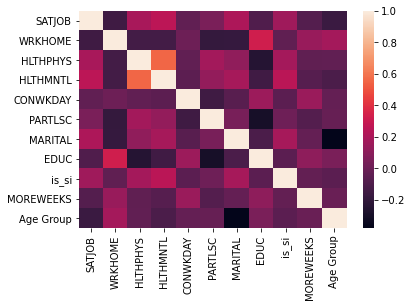

In [5]:
# Checking for multicollinearity- looks good

corr = gss.corr()
sns.heatmap(corr)

In [6]:
# Marital status is the only nominal categorical variable in this dataframe. Using get_dummies to one-hot encode and
# dropping first level of marital status: a zero for marital_2, marital_3, marital_4, and marital_5 implies row belongs
# to marital_1. The rest of the variables are ordinal and attempting to run logit with variables as-is.

gss= pd.get_dummies(gss, columns= ['MARITAL'], prefix= 'Marital', drop_first= True)
gss.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,EDUC,is_si,MOREWEEKS,Age Group,Marital_2.0,Marital_3.0,Marital_4.0,Marital_5.0
0,1.0,1.0,1.0,1.0,4.0,3.0,4,0,1,4,0,0,0,0
1,1.0,1.0,3.0,2.0,3.0,2.0,3,1,1,3,0,1,0,0
2,1.0,1.0,2.0,3.0,4.0,5.0,2,0,4,2,0,0,0,1
3,2.0,1.0,2.0,3.0,4.0,1.0,2,1,1,3,0,0,0,0
4,2.0,1.0,3.0,3.0,2.0,1.0,3,1,1,2,0,0,1,0


In [7]:
# Starting to split data to prepare for modeling

X= gss[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','EDUC', 'MOREWEEKS', 'Age Group', 'Marital_2.0','Marital_3.0', 'Marital_4.0', 'Marital_5.0' ]]
y= gss['is_si']

In [8]:
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os= SMOTEN(random_state= 42)
os_X, os_y= os.fit_resample(X_train, y_train)

In [9]:
# Verifying we now have 50/50 isolated to non-isolated for training data

os_y.value_counts()

1    378
0    378
Name: is_si, dtype: int64

In [10]:
# SATJOB, HLTHPHYS, PARTLSC, MARITAL_2, MARITAL_5 all have p-value above 0.05 lacking statistical significance

import statsmodels.api as sm

sm_logit = sm.Logit(os_y, os_X)
result = sm_logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.563325
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  756
Model:                          Logit   Df Residuals:                      743
Method:                           MLE   Df Model:                           12
Date:                Sun, 02 Apr 2023   Pseudo R-squ.:                  0.1873
Time:                        23:12:56   Log-Likelihood:                -425.87
converged:                       True   LL-Null:                       -524.02
Covariance Type:            nonrobust   LLR p-value:                 1.899e-35
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
SATJOB         -0.1477      0.122     -1.212      0.226      -0.387       0.091
WRKHOME        -0.3397    

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

sk_logit = LogisticRegression()
sk_logit.fit(os_X, os_y)
y_pred = sk_logit.predict(X_test)
print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))

Accuracy on test set:0.68


In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.71      0.78       164
           1       0.33      0.53      0.41        43

    accuracy                           0.68       207
   macro avg       0.59      0.62      0.59       207
weighted avg       0.74      0.68      0.70       207

